#notebook.binary_pattern_task

We solve the simple pattern completion problem (introduced in https://arxiv.org/abs/quant-ph/9807053) and some of its variants with the proposed architectures.

We focus on a pattern completion problem associated to the language of binary strings $L = \{y0a : y \in \{0, 1\}^*, a \in \{0, 1\}\}$, where the penultimate symbol is zero. We will focus on $m=4$ binary patterns of length $n=4$ where $y$ are binary patterns extracted from a set of patterns with different sizes.

I needed execute the following commands
```
!git clone https://github.com/leonardoLavagna/qhdc
import os
os.chdir('qhdc')
!pip install -r requirements.txt
```

### QuAM-based architecture

In [4]:
from functions.patterns_utilities import *
from functions.QUAM import *
from qiskit.visualization import plot_histogram

In [5]:
def process_string(input_string):
  """
  Eliminates the first part of a string based on a space delimiter.

  Args:
    input_string: The input string.

  Returns:
    The processed string with the first part removed, or the original string if no space is found.
  """
  parts = input_string.split(" ", 1)
  if len(parts) > 1:
    return parts[1]
  else:
    return input_string

In [6]:
# Load patterns
file_path = os.path.join('data', 'binary_patterns_n4k4.txt')
patterns = []
with open(file_path, 'r') as file:
  for line in file:
    patterns.append(line.strip())

In [7]:
# Preprocessing... make data compatible with the chose language
patterns = [p for p in patterns if p[-2] == '0']
patterns = list(set(patterns))
patterns

['1000', '0100', '0001']

In [8]:
# Load incomplete patterns
file_path = os.path.join('data', 'binary_patterns_n4k8.txt')
searches = []
with open(file_path, 'r') as file:
  for line in file:
    searches.append(line.strip())

In [9]:
# Preprocessing... make data compatible with the chose language
# Remark: here '?' corresponds to an unknown bit ω
searches = [s[:len(s)-1] for s in searches if s[-2] == '0']
searches = [s + "?" for s in searches]
searches = list(set(searches))
searches

['000?', '100?', '010?']

In [10]:
# Pattern completion/search results with a basic QuAM
results_1 = []
for search in searches:
  state, data = QuAM(patterns, search=search)
  sorted_data = sorted(data.items(), key=lambda item: item[1], reverse=True)
  results_1.append((search,sorted_data[0][0]))
  print(f"Given {search} the result of the QuAM is {sorted_data[0][0]}")
results_1 = [process_string(r[1]) for r in results_1]

Given 000? the result of the QuAM is 01 0001
Given 100? the result of the QuAM is 01 1000
Given 010? the result of the QuAM is 01 0100


Now we solve an associated similarity problem: given a string search not in the QuAM extract from the QuAM the most similar pattern. There are two options

**Option 1**

- Generate a boolean expression `expression = similarity(patterns,search)`.
- Build an oracle `PhaseOracle(expression)`
- Carry out a Grover search with given oracle

**Option 2**

- Prepare the state `|similarity(patterns, search)>`
- Run a standard Grover search in the extended database `|patterns>, |similarity(patterns, search)>`.

We focus on Option 1.

In [11]:
# Pattern completion/search results with a QuAM-based architecture
results_2 = []
for search in searches:
  result = grover_search(qc=None, x=None, c=None, output=None, xc=None, cc=None, R=None,
                        s=search, patterns=patterns, problem="similarity")
  data = result.circuit_results[0]
  sorted_data = sorted(data.items(), key=lambda item: item[1], reverse=True)
  results_2.append((search,sorted_data[0][0]))
  print(f"Given {search} the result of the QuAM-based architecture is {sorted_data[0][0]}")

Given 000? the result of the QuAM-based architecture is 0001
Given 100? the result of the QuAM-based architecture is 1000
Given 010? the result of the QuAM-based architecture is 0100


To conclude this part we consider a specific example where the set of patterns is `
['1000', '0100', '0001']` and the incomplete pattern is `'010?` in both previous cases.

0.58 |0001> + 0.58 |0100> + 0.58 |1000>


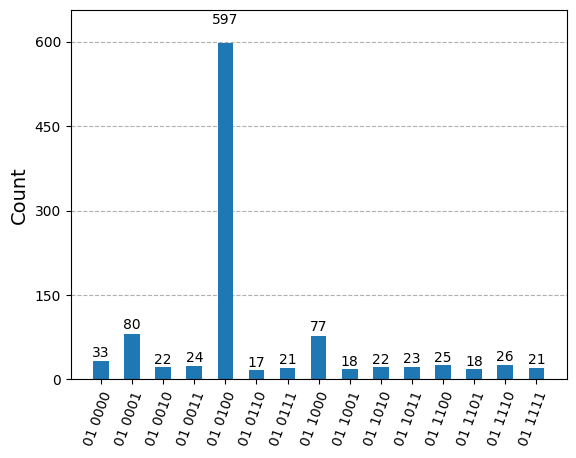

In [12]:
state, data = QuAM(patterns, search="010?")
print(state)
plot_histogram(data)

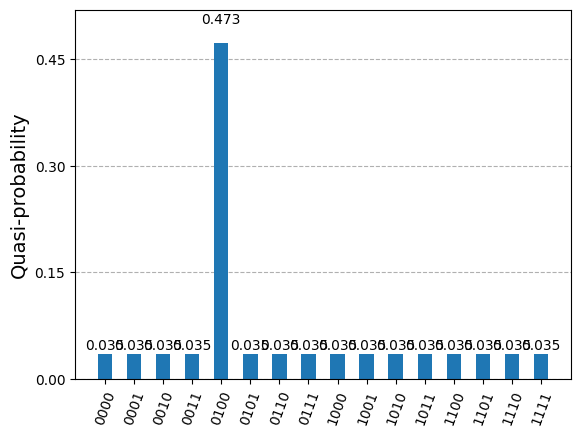

In [13]:
result = grover_search(qc=None, x=None, c=None, output=None, xc=None, cc=None, R=None,
                       s="010?", patterns=patterns, problem="similarity")
display(plot_histogram(result.circuit_results[0]))

0.58 |0001> + 0.58 |0100> + 0.58 |1000>


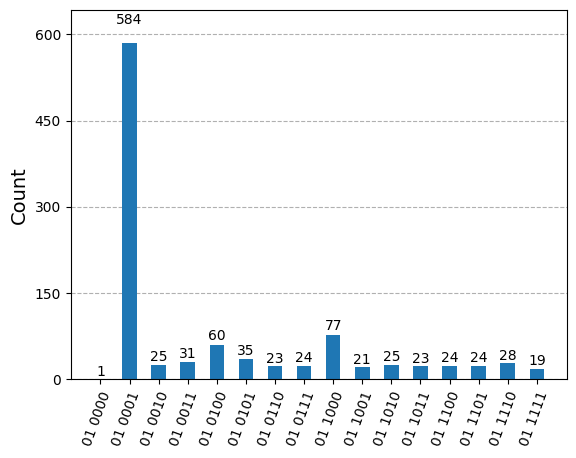

In [14]:
state, data = QuAM(patterns, search="000?")
print(state)
plot_histogram(data)

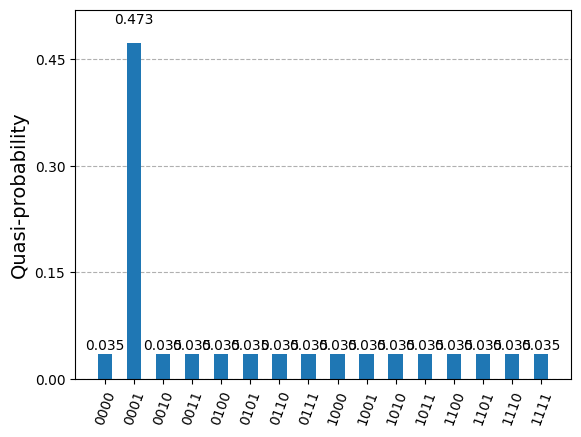

In [15]:
result = grover_search(qc=None, x=None, c=None, output=None, xc=None, cc=None, R=None,
                       s="000?", patterns=patterns, problem="similarity")
display(plot_histogram(result.circuit_results[0]))

### Circuit-based architecture
We repeat the previous steps with the Circuit-based architecture. Notice that the pattern completion problem is a special case of the pattern search problem, so we focus on this one.

In [16]:
# Create the dictionary of (direct) quantum circuits encoding the patterns
n = math.ceil(math.log2(len(patterns))) + 1
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
qc_1 = encode_bitstring(patterns[0], qr, cr)
qc_2 = encode_bitstring(patterns[1], qr, cr)
qc_3 = encode_bitstring(patterns[2], qr, cr)
circs = {patterns[0]: qc_1, patterns[1]: qc_2, patterns[2]: qc_3}

In [17]:
# Generate the inverse circuits associated to the previous ones
inv_qc_1 = encode_bitstring(patterns[0], qr, cr, inverse=True)
inv_qc_2 = encode_bitstring(patterns[1], qr, cr, inverse=True)
inv_qc_3 = encode_bitstring(patterns[2], qr, cr, inverse=True)
inv_circs = {patterns[0]: inv_qc_1, patterns[1]: inv_qc_2, patterns[2]: inv_qc_3}

In [18]:
# Pattern completion/search results with a circuit-based architecture
shots = 1024
combined_circs = {}
count = {}
most_similar, most_similar_score = "", -1.0
for other_key in inv_circs:
    if other_key == search:
        continue
    combined_circs[other_key] = circs[other_key].compose(inv_circs[other_key])
    backend = Aer.get_backend("qasm_simulator")
    t_qc = transpile(combined_circs[other_key], backend=backend)
    job = backend.run(t_qc)
    st = job.result().get_counts(combined_circs[other_key])
    if "0"*n in st:
        sim_score = st["0"*n]/shots
    else:
        sim_score = 0.0
    print("Similarity score of",search,"and",other_key,"is",sim_score)
    if most_similar_score < sim_score:
        most_similar, most_similar_score = other_key, sim_score
print(search,"is most similar to", most_similar)

Similarity score of 010? and 1000 is 0.0
Similarity score of 010? and 0100 is 0.2412109375
Similarity score of 010? and 0001 is 0.2490234375
010? is most similar to 0001


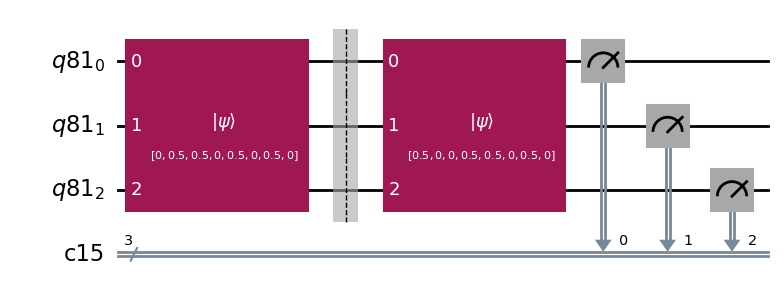

In [19]:
# A specific case...
qc_1.compose(inv_qc_2).draw(output='mpl', style={'decompose': True})